# 4.0 - Sklearn Pipeline Best Practices - Team 34
Demonstration of scikit-learn Pipeline for automated ML workflows

This notebook demonstrates industry best practices using sklearn's Pipeline API.

## Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our pipeline builder
from fase2.pipeline_builder import PipelineBuilder, create_full_pipeline
from fase2.config import config
#from fase2.pipeline import MLPipeline

print("✓ Imports successful")

✓ Imports successful


## Why sklearn Pipelines?

**Benefits:**
1. ✅ **No Data Leakage:** Preprocessing fitted only on training data
2. ✅ **Reproducibility:** Single object encapsulates entire workflow
3. ✅ **Automation:** One `.fit()` call for everything
4. ✅ **Deployment Ready:** Single `.pkl` file to deploy
5. ✅ **Grid Search:** Tune preprocessing + model parameters together

## 1. Load PROCESSED Data

**Important:** The sklearn Pipeline should work with ALREADY CLEANED data.
We use the processed train/test splits from feature engineering.

In [7]:
from fase2.config import config
import pandas as pd

# Load processed data (already cleaned, split, and ready)
X_train = pd.read_csv(config.paths.processed_data_dir / 'X_train.csv')
X_test = pd.read_csv(config.paths.processed_data_dir / 'X_test.csv')
y_train = pd.read_csv(config.paths.processed_data_dir / 'y_train.csv').values.ravel()
y_test = pd.read_csv(config.paths.processed_data_dir / 'y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nData is already:")
print("  ✓ Cleaned")
print("  ✓ Split into train/test")
print("  ✓ Ready for pipeline")

Training set: (551, 20)
Test set: (138, 20)

Data is already:
  ✓ Cleaned
  ✓ Split into train/test
  ✓ Ready for pipeline


## 2. Build Simplified Pipeline

The pipeline now only handles:
- Imputation (if any NaNs remain)
- Scaling
- Model training

In [9]:
from fase2.pipeline_builder import PipelineBuilder

builder = PipelineBuilder()

# Build simplified pipeline
pipeline = builder.build_pipeline(
    model_name='random_forest',
    #include_outlier_clipping=False  # Data already cleaned
)

# Display structure
print("\n📋 Pipeline Structure:")
steps_df = builder.get_pipeline_steps(pipeline)
print(steps_df.to_string(index=False))

2025-10-29 10:21:25.737 | DEBUG    | fase2.pipeline_builder:__init__:40 - PipelineBuilder initialized
2025-10-29 10:21:25.737 | INFO     | fase2.pipeline_builder:build_pipeline:63 - Building sklearn pipeline for random_forest...
2025-10-29 10:21:25.737 | DEBUG    | fase2.core.model_factory:create_model:58 - Creating Random Forest model with random_state=42
2025-10-29 10:21:25.737 | SUCCESS  | fase2.pipeline_builder:build_pipeline:77 - ✓ Pipeline built with 3 steps
2025-10-29 10:21:25.737 | DEBUG    | fase2.pipeline_builder:build_pipeline:79 -   - imputer: SimpleImputer
2025-10-29 10:21:25.737 | DEBUG    | fase2.pipeline_builder:build_pipeline:79 -   - scaler: StandardScaler
2025-10-29 10:21:25.737 | DEBUG    | fase2.pipeline_builder:build_pipeline:79 -   - model: RandomForestClassifier



📋 Pipeline Structure:
   Step            Transformer
imputer          SimpleImputer
 scaler         StandardScaler
  model RandomForestClassifier


## 3. Train Pipeline

In [10]:
print("Training pipeline...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import accuracy_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"\n✓ Pipeline trained!")
print(f"  Test Accuracy: {accuracy:.4f}")
print(f"  Test AUC-ROC: {auc:.4f}")

Training pipeline...

✓ Pipeline trained!
  Test Accuracy: 0.7609
  Test AUC-ROC: 0.8119


## 4. GridSearchCV for Hyperparameter Tuning

GridSearchCV allows us to find the best hyperparameters automatically using cross-validation. This is integrated seamlessly with our pipeline.

In [11]:
print("=" * 70)
print("TRAINING WITH GRIDSEARCHCV")
print("=" * 70)

# Build GridSearch pipeline with reduced grid for demo
grid_pipeline = builder.build_grid_search_pipeline(
    model_name='random_forest',
    cv_folds=3,  # 3-fold CV for speed
    param_grid={
        'model__n_estimators': [50, 100],        # 2 values
        'model__max_depth': [10, 20, None],      # 3 values
        'model__min_samples_split': [2, 5]       # 2 values
        # Total: 2 × 3 × 2 = 12 combinations × 3 folds = 36 fits
    }
)

print(f"\nParameter grid: 12 combinations")
print(f"Cross-validation: 3 folds")
print(f"Total fits: 36\n")

2025-10-29 10:21:31.158 | INFO     | fase2.pipeline_builder:build_grid_search_pipeline:106 - Building GridSearchCV pipeline for random_forest...
2025-10-29 10:21:31.158 | INFO     | fase2.pipeline_builder:build_pipeline:63 - Building sklearn pipeline for random_forest...
2025-10-29 10:21:31.160 | DEBUG    | fase2.core.model_factory:create_model:58 - Creating Random Forest model with random_state=42
2025-10-29 10:21:31.160 | SUCCESS  | fase2.pipeline_builder:build_pipeline:77 - ✓ Pipeline built with 3 steps
2025-10-29 10:21:31.162 | DEBUG    | fase2.pipeline_builder:build_pipeline:79 -   - imputer: SimpleImputer
2025-10-29 10:21:31.162 | DEBUG    | fase2.pipeline_builder:build_pipeline:79 -   - scaler: StandardScaler
2025-10-29 10:21:31.162 | DEBUG    | fase2.pipeline_builder:build_pipeline:79 -   - model: RandomForestClassifier
2025-10-29 10:21:31.164 | INFO     | fase2.pipeline_builder:build_grid_search_pipeline:119 - Parameter grid: ['model__n_estimators', 'model__max_depth', 'model_

TRAINING WITH GRIDSEARCHCV

Parameter grid: 12 combinations
Cross-validation: 3 folds
Total fits: 36



In [12]:
# Train
import time
start_time = time.time()
grid_pipeline.fit(X_train, y_train)
elapsed_time = time.time() - start_time

print(f"\n✓ GridSearch complete in {elapsed_time:.2f} seconds!")
print(f"  Best CV Score: {grid_pipeline.best_score_:.4f}")
print(f"  Best Params:")
for param, value in grid_pipeline.best_params_.items():
    print(f"    {param}: {value}")
    



Fitting 3 folds for each of 12 candidates, totalling 36 fits

✓ GridSearch complete in 6.78 seconds!
  Best CV Score: 0.7949
  Best Params:
    model__max_depth: 10
    model__min_samples_split: 5
    model__n_estimators: 50


### Compare: Simple vs Optimized Pipeline

In [13]:
# Get best pipeline
best_pipeline = grid_pipeline.best_estimator_

# Evaluate on test set
y_pred_best = best_pipeline.predict(X_test)
y_proba_best = best_pipeline.predict_proba(X_test)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_proba_best)

# Create comparison table
comparison = pd.DataFrame({
    'Pipeline': ['Simple (default)', 'GridSearch (optimized)'],
    'Accuracy': [accuracy, accuracy_best],
    'AUC-ROC': [auc, auc_best],
    'Improvement': [0, (auc_best - auc) * 100]
})

print("\n📊 COMPARISON:")
print(comparison.to_string(index=False))

if auc_best > auc:
    print(f"\n✅ GridSearch improved AUC by {(auc_best - auc)*100:.2f}%!")
else:
    print(f"\nℹ️  GridSearch found similar performance (difference: {abs(auc_best - auc)*100:.2f}%)")


📊 COMPARISON:
              Pipeline  Accuracy  AUC-ROC  Improvement
      Simple (default)  0.760870 0.811881     0.000000
GridSearch (optimized)  0.746377 0.819641     0.776024

✅ GridSearch improved AUC by 0.78%!


## Register pipeline metrics in MlFlow

In [15]:
# Setup integration with MLFlow server
import mlflow
import mlflow.sklearn

remote_server_uri = "http://34.67.152.248:5000/"
mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("/south_german_credit_risk_experiment_001")

<Experiment: artifact_location='gs://tidy-discipline-476410-r5-mlflow-artifacts/mlflow-artifacts/2', creation_time=1761710172468, experiment_id='2', last_update_time=1761710172468, lifecycle_stage='active', name='/south_german_credit_risk_experiment_001', tags={}>

In [16]:
best_model_name = "random_forest_optimized"

with mlflow.start_run(run_name=f"{best_model_name.replace('_', ' ').title()} Pipeline"):

    # Log parameters
    mlflow.log_param("Model", best_model_name)
    for key, value in grid_pipeline.best_params_.items():
        mlflow.log_param(key, value)

    # Log metrics        
    mlflow.log_metric("Accuracy", auc_best)
    mlflow.log_metric("AUC-ROC", auc_best)

    # Create an MLflow Dataset object from the DataFrame
    mlflow_dataset = mlflow.data.from_pandas(df=X_train, name="german_credit_cleaned.csv")

    # Log the dataset to the current MLflow run
    mlflow.log_input(mlflow_dataset, context="training")

    # Log pipeline
    print(f"✅ {best_model_name} pipeline logged to MLflow")

mlflow.end_run()

✅ random_forest_optimized pipeline logged to MLflow
🏃 View run Random Forest Optimized Pipeline at: http://34.67.152.248:5000/#/experiments/2/runs/8c968080d5a04c25a4cb080beed024f8
🧪 View experiment at: http://34.67.152.248:5000/#/experiments/2


### Visualize GridSearch Results

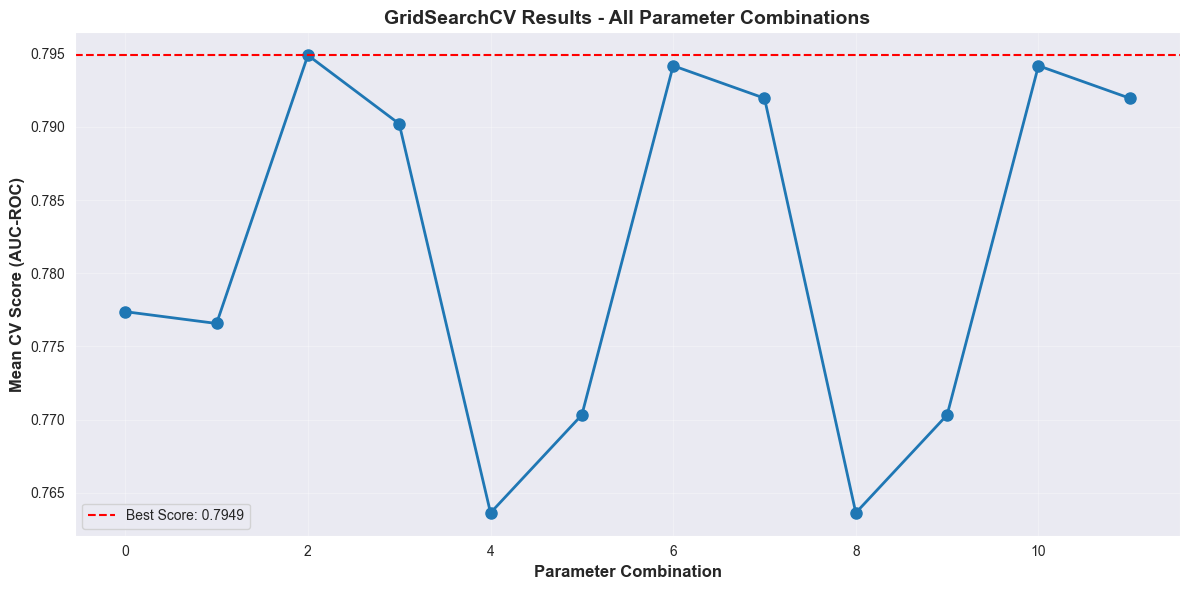


Best combination was #3


In [14]:
# Extract CV results
cv_results = pd.DataFrame(grid_pipeline.cv_results_)

# Plot mean test scores
plt.figure(figsize=(12, 6))
plt.plot(cv_results['mean_test_score'], marker='o', linewidth=2, markersize=8)
plt.axhline(y=cv_results['mean_test_score'].max(), color='r', linestyle='--', 
            label=f'Best Score: {cv_results["mean_test_score"].max():.4f}')
plt.xlabel('Parameter Combination', fontsize=12, fontweight='bold')
plt.ylabel('Mean CV Score (AUC-ROC)', fontsize=12, fontweight='bold')
plt.title('GridSearchCV Results - All Parameter Combinations', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest combination was #{ cv_results['mean_test_score'].idxmax() + 1}")